# Example use: Tidal Heating

The following example applies BHPwave to the modified tidal heating setup of https://arxiv.org/pdf/1910.07841. Please cite that reference as well as the bhpwave sources if this is of interest to you. 

Aside from BHPWave, LISATools will be used for part of the example

we start by loading useful modules. lisatools or other non-standard modules aside from bhpwave will only be imported later as needed.

In [1]:
#useful constants
from bhpwave.constants import *

#Geodesic motion
from bhpwave.trajectory.geodesic import *

#adiabatic inspiral, from precomputed trajectory data
from bhpwave.trajectory.inspiral import InspiralGenerator, TrajectoryData, Inspiral

#adiabatic inspiral with user costum input flux
from bhpwave.trajectory.inspiral import IntegrateInspiralGeneratorBase

#smaller functionality for processing how certain data was stored
from bhpwave.trajectory.inspiral import pn_flux_noprefactor, spin_of_chi
from bhpwave.spline import BicubicSpline

#waveform generation
from bhpwave.waveform import KerrCircularWaveform, KerrWaveform, KerrFrequencyWaveform

#useful standard python libraries
import matplotlib.pyplot as plt
import numpy as np
import time
import os

## Evolution of the orbital radius from precomputed trajectory data

We start by studying the unmodified inspiral. Giving in particular a comparison between the different values of the central black hole spin

In [2]:
#based on precomputed data in the trajectory.txt file
path_to_file = os.path.abspath("")
path = path_to_file + "/data/trajectory.txt"

In [3]:
trajdata=TrajectoryData(path, dealloc_flag=False)

In [4]:
inspiral_gen = InspiralGenerator(trajectory_data=trajdata)
M=10**6
mu=30

a998=0.998
a8=0.8
a5=0.5
a3=0.3

p0=10
dt = 10.0  # time steps in seconds
T = 1.5  # waveform duration in years

#
#'''
#actually generate the inspirals for different spins
start = time.time()
inspiral_998=inspiral_gen(M,mu,a998,p0,dt,T)
inspiral_8=inspiral_gen(M,mu,a8,p0,dt,T)
inspiral_5=inspiral_gen(M,mu,a5,p0,dt,T)
inspiral_3=inspiral_gen(M,mu,a3,p0,dt,T)
end = time.time()
print(end - start)
#'''

6.5060505867004395


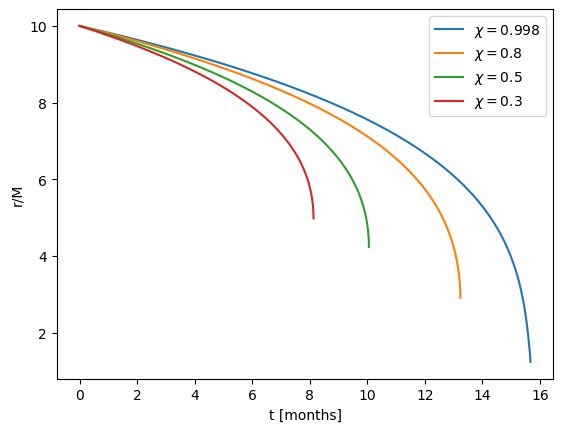

In [5]:
#remark output time in solar masses apparently
ii=0
labellist=[r'$\chi = 0.998$',r'$\chi = 0.8$',r'$\chi = 0.5$',r'$\chi = 0.3$']
ax = plt.gca()
for insp in [inspiral_998,inspiral_8,inspiral_5,inspiral_3]:

    itime=insp.time
    iradius=insp.radius
    
    ax.plot(Modot_GC1_to_S*M*itime/60./60./24./31.,iradius,label=labellist[ii])
    plt.xlabel("t [months]")
    plt.ylabel("r/M")
    ii=ii+1
ax.legend()
plt.show()

## Evolution of the orbital radius computed on the fly

Sometimes one needs more flexibility. So let's do the same as above with more work.

Specifically, we start by specifying the energyflux, we shall use precomputed fluxes from an integration of the Teukolsky equations

In [3]:
filename_flux = "/data/bhpwave_edot.npy"
path_to_file = os.path.abspath("")
flux_array = np.load(path_to_file + filename_flux)

#below we just work towards having a function Edot(omega), provide however you like ...

#Want to interpolate the flux_data, we will do this a couple of times so define a function
def flux_to_norm_spline(Efluxraw):
    #reconstruct mesh (from how data was stored)
    #remark chi and alpha are functions of a and r
    chi_flux_array = np.linspace(0, 1, Efluxraw.shape[0])
    alpha_flux_array = np.linspace(0, 1, Efluxraw.shape[1])
    ALPHA_FLUX, CHI_FLUX = np.meshgrid(alpha_flux_array, chi_flux_array)
    SPIN_FLUX = spin_of_chi(CHI_FLUX)
    OMEGA_FLUX = omega_of_a_alpha(SPIN_FLUX, ALPHA_FLUX)

    #will want to normalize to PN flux
    Efluxraw_norm=Efluxraw/pn_flux_noprefactor(OMEGA_FLUX)
    flux_spline = BicubicSpline(chi_flux_array, alpha_flux_array, Efluxraw_norm, bc = 'E(3)')
    return flux_spline

edot_norm_spline = flux_to_norm_spline(flux_array)

In [4]:
integrator=IntegrateInspiralGeneratorBase(Edot_norm = edot_norm_spline)

In [5]:
#for comparison use the same parameters as in the previous section
M=10**6
mu=30

a998=0.998
a8=0.8
a5=0.5
a3=0.3

p0=10
dt = 10.0  # time steps in seconds
T = 1.5  # waveform duration in years

start = time.time()
inspiral_998=integrator(M, mu, a998, p0, dt, T)
inspiral_8=integrator(M, mu, a8, p0, dt, T)
inspiral_5=integrator(M, mu, a5, p0, dt, T)
inspiral_3=integrator(M, mu, a3, p0, dt, T)
end = time.time()
print(end - start)

3.1677358150482178


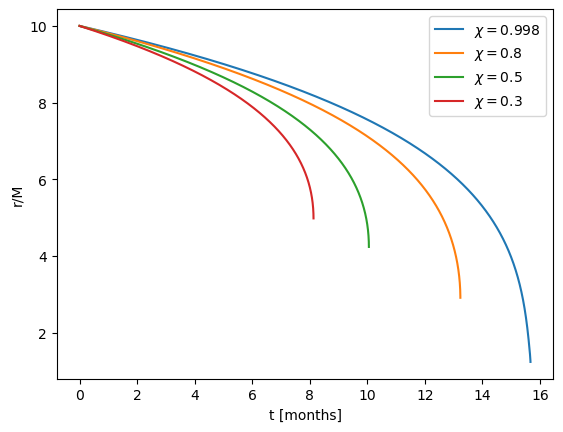

In [6]:
#remark output time in solar masses apparently
ii=0
labellist=[r'$\chi = 0.998$',r'$\chi = 0.8$',r'$\chi = 0.5$',r'$\chi = 0.3$']
ax = plt.gca()
for insp in [inspiral_998,inspiral_8,inspiral_5,inspiral_3]:

    itime=insp.time
    iradius=insp.radius
    
    ax.plot(Modot_GC1_to_S*M*itime/60./60./24./31.,iradius,label=labellist[ii])
    plt.xlabel("t [months]")
    plt.ylabel("r/M")
    ii=ii+1
ax.legend()
plt.show()

## Evolution of the phase difference (precomputed)

Let us now introduce the tidal heating model of https://arxiv.org/pdf/1910.07841

First, as above, we use precomputed trajectory data. Then we simply provide the energy-fluxes and compute the trajectories as we go

In [7]:
path_to_file = os.path.abspath("")
pathmod = path_to_file + "/data/trajectoryC1000000ppm.txt"
pathGR = path_to_file + "/data/trajectory.txt"

trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)

In [8]:
M=10**6
mu=30
p0=10
a998=0.998
a8=0.8
a5=0.5
a3=0.3
dt = 10.0  # time steps in seconds
T = 1.5  # waveform duration in years

In [9]:
inspiral_gen_GR = InspiralGenerator(trajectory_data=trajdata_GR)
inspiral_gen_mod = InspiralGenerator(trajectory_data=trajdata_mod)

In [10]:
#'''
start = time.time()
inspiral_998=inspiral_gen_GR(M,mu,a998,p0,dt,T)
inspiral_8=inspiral_gen_GR(M,mu,a8,p0,dt,T)
inspiral_5=inspiral_gen_GR(M,mu,a5,p0,dt,T)
inspiral_3=inspiral_gen_GR(M,mu,a3,p0,dt,T)
end = time.time()
print(end - start)
#'''

7.257776498794556


In [11]:
#'''
start = time.time()
inspiral_998_mod=inspiral_gen_mod(M,mu,a998,p0,dt,T)
inspiral_8_mod=inspiral_gen_mod(M,mu,a8,p0,dt,T)
inspiral_5_mod=inspiral_gen_mod(M,mu,a5,p0,dt,T)
inspiral_3_mod=inspiral_gen_mod(M,mu,a3,p0,dt,T)
end = time.time()
print(end - start)
#'''

6.665129661560059


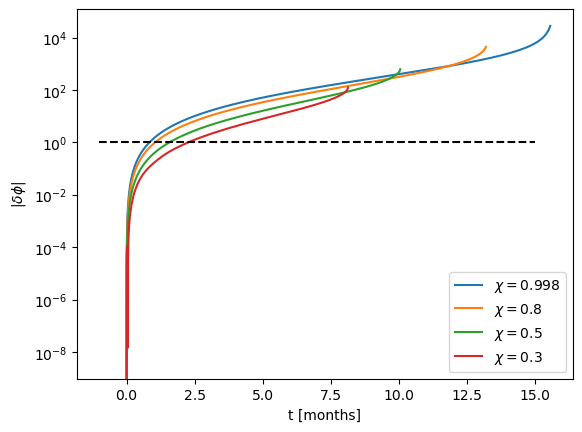

In [12]:
#assume something is still not great in the interpolation
labellist=[r'$\chi = 0.998$',r'$\chi = 0.8$',r'$\chi = 0.5$',r'$\chi = 0.3$']
insplist=[inspiral_998,inspiral_8,inspiral_5,inspiral_3]
insplistmod=[inspiral_998_mod,inspiral_8_mod,inspiral_5_mod,inspiral_3_mod]
ax = plt.gca()
for ii in range(len(insplist)):
    inspgr=insplist[ii]
    inspmod=insplistmod[ii]

    
    itime=inspgr.time
    itimemod=inspmod.time

    iphase=inspgr.phase
    iphasemod=inspmod.phase

    imax=min(len(itime),len(itimemod))
    dphase=2*np.abs(inspgr.phase[:imax]-inspmod.phase[:imax])
    
    plt.semilogy(Modot_GC1_to_S*M*itime[:imax]/60./60./24./31.,dphase,label=labellist[ii])
    plt.xlabel("t [months]")
    plt.ylabel(r"$|\delta \phi|$")
plt.hlines(1, -1, 15,colors='black',linestyles='dashed')
ax.legend()
plt.show()

## Evolution of the phase difference

If one does not want to precompute all the trajectories

In [13]:
#we need separately horizon absorption and flux to asymptotic infinity
filename_flux_H = "/data/bhpwave_edot_H.npy"
filename_flux_Infty = "/data/bhpwave_edot_Infty.npy"
path_to_file = os.path.abspath("")
flux_array_H = np.load(path_to_file + filename_flux_H)
flux_array_Infty = np.load(path_to_file + filename_flux_Infty)


edotH_norm_spline = flux_to_norm_spline(flux_array_H)
edotInfty_norm_spline = flux_to_norm_spline(flux_array_Infty)

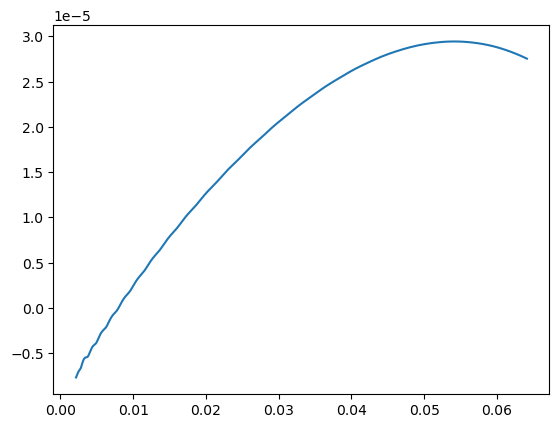

In [14]:
#Sanity check and how good is the precomputed data oops :)
atest=0.9
chitest=chi_of_spin(atest)
rrange=np.linspace(60,6,1000)
omegarange=kerr_circ_geo_orbital_frequency(atest, rrange)
iscotest=kerr_isco_frequency(atest)
alpharange=alpha_of_omega_ISCO(omegarange, iscotest)

difftest=[edotH_norm_spline(chitest,alpha)+edotInfty_norm_spline(chitest,alpha)-edot_norm_spline(chitest,alpha) for alpha in alpharange]
plt.plot(omegarange,difftest)

In [15]:
def Edot_mod(chi,alpha,C):
    return edot_norm_spline(chi,alpha)-C*edotH_norm_spline(chi,alpha)

integrator_mod = IntegrateInspiralGeneratorBase(Edot_norm = Edot_mod)

In [19]:
#for comparison use the same parameters as before
Ctest=1.
Cgr=0.
M=10**6
mu=30
p0=10
a998=0.998
a8=0.8
a5=0.5
a3=0.3
dt = 10.0  # time steps in seconds
T = 1.5  # waveform duration in years

start = time.time()
inspiral_998_mod=integrator_mod(M, mu, a998, p0, dt, T,Ctest)
inspiral_8_mod=integrator_mod(M, mu, a8, p0, dt, T,Ctest)
inspiral_5_mod=integrator_mod(M, mu, a5, p0, dt, T,Ctest)
inspiral_3_mod=integrator_mod(M, mu, a3, p0, dt, T,Ctest)
end = time.time()
print(end - start)

start = time.time()
inspiral_998=integrator_mod(M, mu, a998, p0, dt, T,Cgr)
inspiral_8=integrator_mod(M, mu, a8, p0, dt, T,Cgr)
inspiral_5=integrator_mod(M, mu, a5, p0, dt, T,Cgr)
inspiral_3=integrator_mod(M, mu, a3, p0, dt, T,Cgr)
end = time.time()
print(end - start)

2.9713895320892334
2.1127099990844727


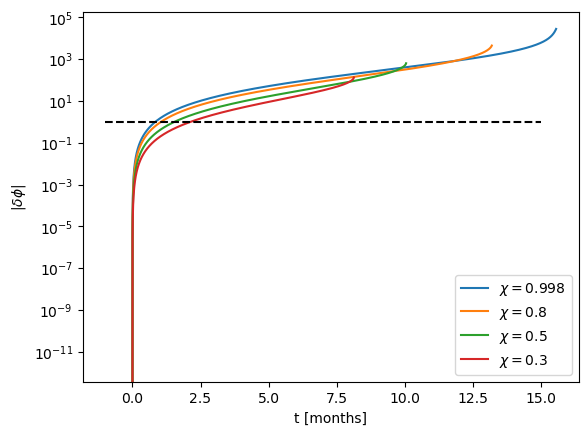

In [20]:
#assume something is still not great in the interpolation
labellist=[r'$\chi = 0.998$',r'$\chi = 0.8$',r'$\chi = 0.5$',r'$\chi = 0.3$']
insplist=[inspiral_998,inspiral_8,inspiral_5,inspiral_3]
insplistmod=[inspiral_998_mod,inspiral_8_mod,inspiral_5_mod,inspiral_3_mod]
ax = plt.gca()
for ii in range(len(insplist)):
    inspgr=insplist[ii]
    inspmod=insplistmod[ii]

    
    itime=inspgr.time
    itimemod=inspmod.time

    iphase=inspgr.phase
    iphasemod=inspmod.phase

    imax=min(len(itime),len(itimemod))
    dphase=2*np.abs(inspgr.phase[:imax]-inspmod.phase[:imax])
    
    plt.semilogy(Modot_GC1_to_S*M*itime[:imax]/60./60./24./31.,dphase,label=labellist[ii])
    plt.xlabel("t [months]")
    plt.ylabel(r"$|\delta \phi|$")
plt.hlines(1, -1, 15,colors='black',linestyles='dashed')
ax.legend()
plt.show()

Having compare both approaches, let us now compare final phase as a function of the tidal heating parameter C

In [23]:
#function to compare final phases

def deltaphifun(M,mu,a,p0,dt,T,C):
    insmod=integrator_mod(M,mu,a,p0,dt,T,C)
    insgr=integrator_mod(M,mu,a,p0,dt,T,0.)
    
    iphase=insgr.phase
    iphasemod=insmod.phase

    #gravitational wave phase
    return 2*(iphase[-1]-iphasemod[-1])

In [24]:
deltaphifun(M,mu,a998,p0,dt,T,1)*mu/M

0.36501514932053747

In [27]:
Cvalues=np.linspace(0,1,10)
deltphivalues998=Cvalues*0.
deltphivalues8=Cvalues*0.
deltphivalues5=Cvalues*0.
deltphivalues3=Cvalues*0.
ii=0
for C in Cvalues:
    deltphivalues998[ii] = deltaphifun(M,mu,a998,p0,dt,T,C)*mu/M
    deltphivalues8[ii] = deltaphifun(M,mu,a8,p0,dt,T,C)*mu/M
    deltphivalues5[ii] = deltaphifun(M,mu,a5,p0,dt,T,C)*mu/M
    deltphivalues3[ii] = deltaphifun(M,mu,a3,p0,dt,T,C)*mu/M
    ii=ii+1


Text(0, 0.5, '$|\\Delta \\phi|\\times (\\frac{\\mu}{M})$')

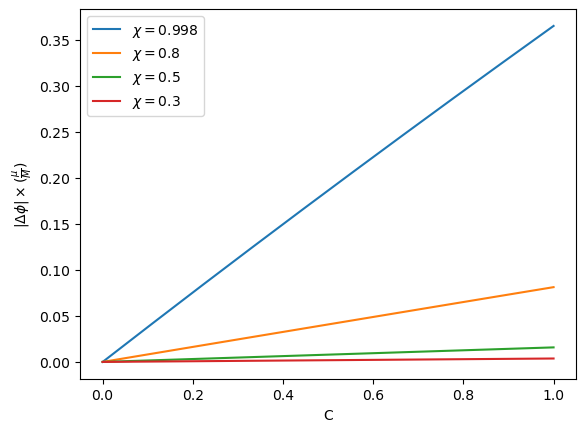

In [28]:
plt.plot(Cvalues,deltphivalues998,label=r'$\chi = 0.998$')
plt.plot(Cvalues,deltphivalues8,label=r'$\chi = 0.8$')
plt.plot(Cvalues,deltphivalues5,label=r'$\chi = 0.5$')
plt.plot(Cvalues,deltphivalues3,label=r'$\chi = 0.3$')

plt.legend()
plt.xlabel("C")
plt.ylabel(r"$|\Delta \phi|\times (\frac{\mu}{M})$")

## A waveform

Let us now finally consider a waveform associated to these inspirals

In [20]:
path_to_file = os.path.abspath("")
pathmod = path_to_file + "/data/trajectoryC1000000ppm.txt"
pathGR = path_to_file + "/data/trajectory.txt"

trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)

In [ ]:
integrator_mod(M,mu,a,p0,dt,T,C)

In [21]:
kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)
kerr_gen_td_mod = KerrWaveform(trajectory_data=trajdata_mod)

In [22]:
#intrinsic binary
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses

#intrinsic orbital
p0 = 10 # initial semi-latus rectum

#more general orbits
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits

#orbital phases
Phi_phi0 = 0.2 # initial azimuthal position of the secondary

#more general orbits
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits

#extrinsic binary parameters
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc

dt = 5.0  # time steps in seconds
T = 1.0  # waveform duration in years

a9=0.9
a7=0.7

injection_paramters7 = [M, mu, a7, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

injection_paramters9 = [M, mu, a9, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

In [23]:
start = time.time()
h7gr = kerr_gen_td_GR(*injection_paramters7)
h9gr = kerr_gen_td_GR(*injection_paramters9)
end=time.time()
print(end-start)

16.081191778182983


In [24]:
h7mod = kerr_gen_td_mod(*injection_paramters7)
h9mod = kerr_gen_td_mod(*injection_paramters9)

In [25]:
t7gr = np.arange(h7gr.shape[0])*dt/60./60./24.
t7mod = np.arange(h7mod.shape[0])*dt/60./60./24.
print(t7gr[400000])
print(t7mod[400000])

t9gr = np.arange(h9gr.shape[0])*dt/60./60./24.
t9mod = np.arange(h9mod.shape[0])*dt/60./60./24.
print(t7gr[400000])
print(t7mod[400000])

23.14814814814815
23.14814814814815
23.14814814814815
23.14814814814815


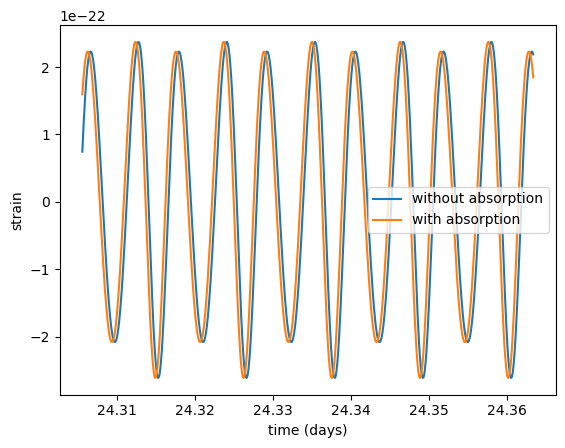

In [26]:
imin=420000
imax=421000
plt.plot(t7gr[imin:imax], h7gr.real[imin:imax],label=r'without absorption')
plt.plot(t7mod[imin:imax], h7mod.real[imin:imax],label=r'with absorption')
plt.xlabel("time (days)")
plt.ylabel("strain")
plt.legend()
plt.show()

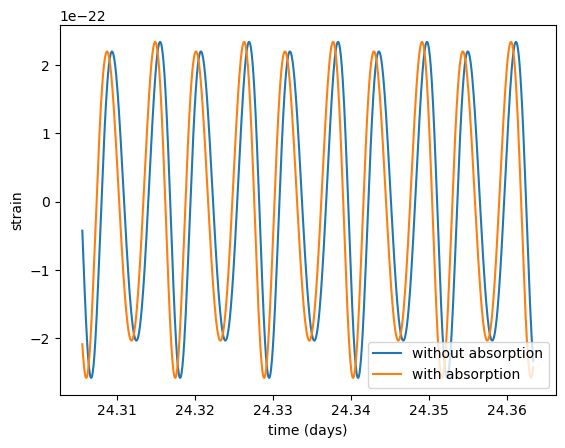

In [27]:
imin=420000
imax=421000
plt.plot(t9gr[imin:imax], h9gr.real[imin:imax],label=r'without absorption')
plt.plot(t9mod[imin:imax], h9mod.real[imin:imax],label=r'with absorption')
plt.xlabel("time (days)")
plt.ylabel("strain")
plt.legend()
plt.show()

## Mismatches FIG4

the deviation parameter is taken to be 1 compared to 0 as in figures 4 of https://arxiv.org/pdf/1910.07841 

In [28]:
#usual setup 

path_to_file = os.path.abspath("")
pathmod = path_to_file + "/data/trajectoryC1000000ppm.txt"
pathGR = path_to_file + "/data/trajectory.txt"

trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)

kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)
kerr_gen_td_mod = KerrWaveform(trajectory_data=trajdata_mod)

kerr_gen_fd_GR = KerrFrequencyWaveform(trajectory_data=trajdata_GR)
kerr_gen_fd_mod = KerrFrequencyWaveform(trajectory_data=trajdata_mod)

In [29]:
#intrinsic binary
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses

#intrinsic orbital
p0 = 10 # initial semi-latus rectum

#more general orbits
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits

#orbital phases
Phi_phi0 = 0.2 # initial azimuthal position of the secondary

#more general orbits
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits

#extrinsic binary parameters
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc

dt = 5.0  # time steps in seconds
T = 1.0  # waveform duration in years

a998=0.998
a9=0.9
a7=0.7

injection_paramters7 = [M, mu, a7, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

injection_paramters9 = [M, mu, a9, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

injection_paramters998 = [M, mu, a998, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

tdwave7=kerr_gen_td_GR(*injection_paramters7)
tdwave7mod=kerr_gen_td_mod(*injection_paramters7)

tdwave9=kerr_gen_td_GR(*injection_paramters9)
tdwave9mod=kerr_gen_td_mod(*injection_paramters9)

tdwave998=kerr_gen_td_GR(*injection_paramters998)
tdwave998mod=kerr_gen_td_mod(*injection_paramters998)

In [30]:
tdwave7.shape

(6311630,)

In [31]:
val = inner_product(tdwave7, tdwave7, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1", stochastic_params=(YRSID_SI,)))
print(f"Inner product <h1|h2>: {val}")

/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = S

Inner product <h1|h2>: 2516.4513592257663


In [32]:
complex_val = inner_product(tdwave7, tdwave7, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1", stochastic_params=(YRSID_SI,)), complex=True)
print(f"Complex inner product <h1|h2>: {complex_val}, phase maximized value: {np.abs(complex_val)}")


Complex inner product <h1|h2>: (2516.4513592257667+8.469650185332515e-17j), phase maximized value: 2516.4513592257667


In [33]:
normalized_val = inner_product(tdwave7, tdwave7, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1", stochastic_params=(YRSID_SI,)), normalize=True)
print(f"Normalized inner product <h1|h2>: {normalized_val}")

Normalized inner product <h1|h2>: 1.0


In [34]:
### following are some mismatches: do more systematically to reproduce plots in paper!

In [35]:
1-inner_product(tdwave7, tdwave7mod, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1"), normalize=True)

0.9864529921300643

In [36]:
1-inner_product(tdwave9, tdwave9mod, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1"), normalize=True)

0.984574669919003

In [37]:
1-inner_product(tdwave998, tdwave998mod, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1"), normalize=True)

0.9849343006086386

## Fisher information matrix

notably absent from https://arxiv.org/pdf/1910.07841 

here approach is to try with lisatools

First import some additional modules

In [ ]:
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

In [11]:
pathname = "/data/trajectoryCtemp.txt"
Ctest=0
alphanum=2**6+1
chinu=2**6+1
generate_mod_trajectories(Ctest,pathname, chi_sample_num = chinu, alpha_sample_num = alphanum)
#generate_mod_trajectories(Ctest,pathname, chi_sample_num = 2**8 + 1, alpha_sample_num = 2**8 + 1)
#generate_mod_trajectories(Ctest,pathname)

Generating time, phase, and frequency evolution
/home/user496/Documents/work/post-PHD_2/bhpwave_Nasipak_sprint/bhpwave/data/trajectoryCtemp.txt
Saving trajectory data to /home/user496/Documents/work/post-PHD_2/bhpwave_Nasipak_sprint/bhpwave/data/trajectoryCtemp.txt


In [30]:
pathname = f"/data/trajectoryCtemp{10**6*Ctest:.0f}ppm.txt"
print(pathname)

/data/trajectoryCtemp1ppm.txt


In [81]:
alphqnum=2**8+1
chinum=2**8+1
path_to_file = os.path.abspath("")

def waveform_model(C,M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T):
    pathname =  f"/data/trajectoryCtemp{10**6*C:.0f}ppm.txt"
    generate_mod_trajectories(C,pathname, chi_sample_num = chinum, alpha_sample_num = alphqnum)
    pathmod = path_to_file + "/data/trajectoryCtemp.txt"
    #pathGR = path_to_file + "/data/trajectory.txt"
    #trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
    trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)
    #kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)
    kerr_gen_td_mod = KerrWaveform(trajectory_data=trajdata_mod)
    #kerr_gen_fd_GR = KerrFrequencyWaveform(trajectory_data=trajdata_GR)
    #kerr_gen_fd_mod = KerrFrequencyWaveform(trajectory_data=trajdata_mod)
    injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]
    return kerr_gen_td_mod(injection_paramters)

#more general orbits
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits

#orbital phases
Phi_phi0 = 0.2 # initial azimuthal position of the secondary

#more general orbits
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits

#extrinsic binary parameters
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc

dt = 5.0  # time steps in seconds
T = 1.0  # waveform duration in years


def waveform_model_red(C,M, mu, a, p0):
    testpathname = f"/data/trajectoryCtemp{10**6*C:.0f}ppm.txt"
    pathmod = path_to_file + testpathname 
    if not os.path.isfile(pathmod):
        generate_mod_trajectories(C,testpathname, chi_sample_num = chinum, alpha_sample_num = alphqnum)
    #pathGR = path_to_file + "/data/trajectory.txt"
    #trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
    trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)
    #kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)
    kerr_gen_td_mod = KerrWaveform(trajectory_data=trajdata_mod)
    #kerr_gen_fd_GR = KerrFrequencyWaveform(trajectory_data=trajdata_GR)
    #kerr_gen_fd_mod = KerrFrequencyWaveform(trajectory_data=trajdata_mod)
    injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]   
    return kerr_gen_td_mod(*injection_paramters)

fn = np.logspace(-8, 0, 100000)
def waveform_model_fd_red(C,M, mu, a, p0):
    testpathname = f"/data/trajectoryCtemp{10**6*C:.0f}ppm.txt"
    pathmod = path_to_file + testpathname 
    if not os.path.isfile(pathmod):
        generate_mod_trajectories(C,testpathname, chi_sample_num = chinum, alpha_sample_num = alphqnum)
    #pathGR = path_to_file + "/data/trajectory.txt"
    #trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
    trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)
    #kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)
    kerr_gen_fd_mod = KerrFrequencyWaveform(trajectory_data=trajdata_mod)
    #kerr_gen_fd_GR = KerrFrequencyWaveform(trajectory_data=trajdata_GR)
    #kerr_gen_fd_mod = KerrFrequencyWaveform(trajectory_data=trajdata_mod)
    injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]   
    return kerr_gen_fd_mod(*injection_paramters,frequencies=fn)

In [82]:
Cref=0.1
aref=0.9
#intrinsic binary
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses

#intrinsic orbital
p0 = 10 # initial semi-latus rectum


refparams = [Cref, M, mu, aref, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

refparamsred = [Cref, M, mu, aref, p0]

refwave=waveform_model_red(*refparamsred)
refwavefd=waveform_model_fd_red(*refparamsred)

In [83]:
rho2= inner_product(refwave, refwave, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1", stochastic_params=(YRSID_SI,)))
print(rho2)

/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = S

1057.2509593349985


/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/stochastic.py:177: RuntimeWarning: divide by zero encountered in power
  * (f ** (-7.0 / 3.0))


In [88]:
rho2= inner_product(refwavefd, refwavefd, f_arr=fn, psd="LISASens", psd_kwargs=dict(model="scirdv1"))
print(rho2)

5688.545151195498


In [89]:
eps = 10**(-6)
FIM=info_matrix(eps, waveform_model_red, refparamsred,inner_product_kwargs={'dt':dt,'psd':"LISASens",'psd_kwargs':dict(model="scirdv1")})

In [94]:
eps = 10**(-6)
FIM=info_matrix(eps, waveform_model_fd_red, refparamsred,inner_product_kwargs={'f_arr':fn})

In [97]:
cov=np.linalg.inv(FIM)

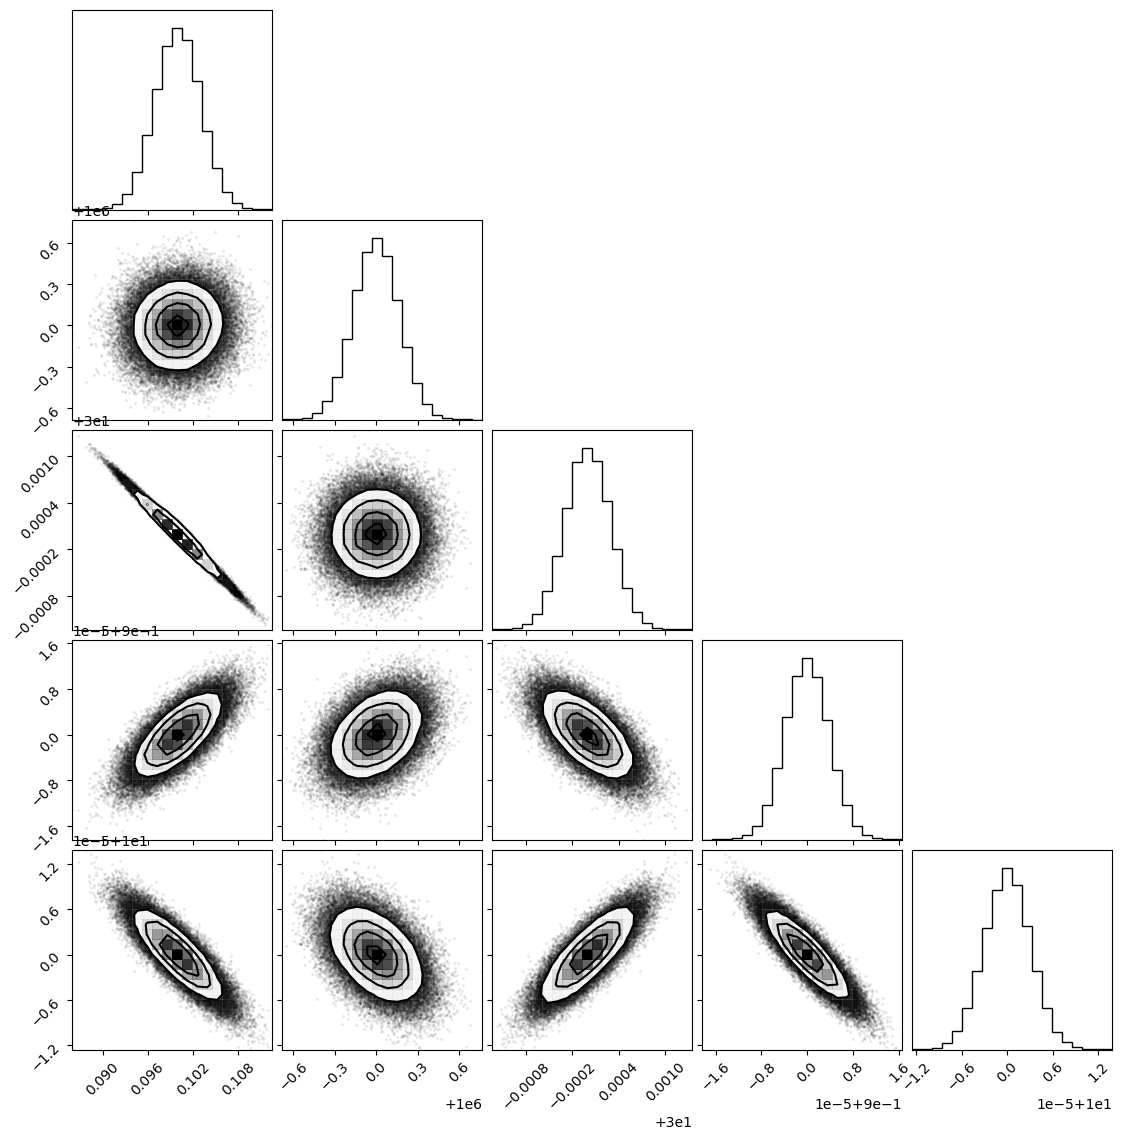

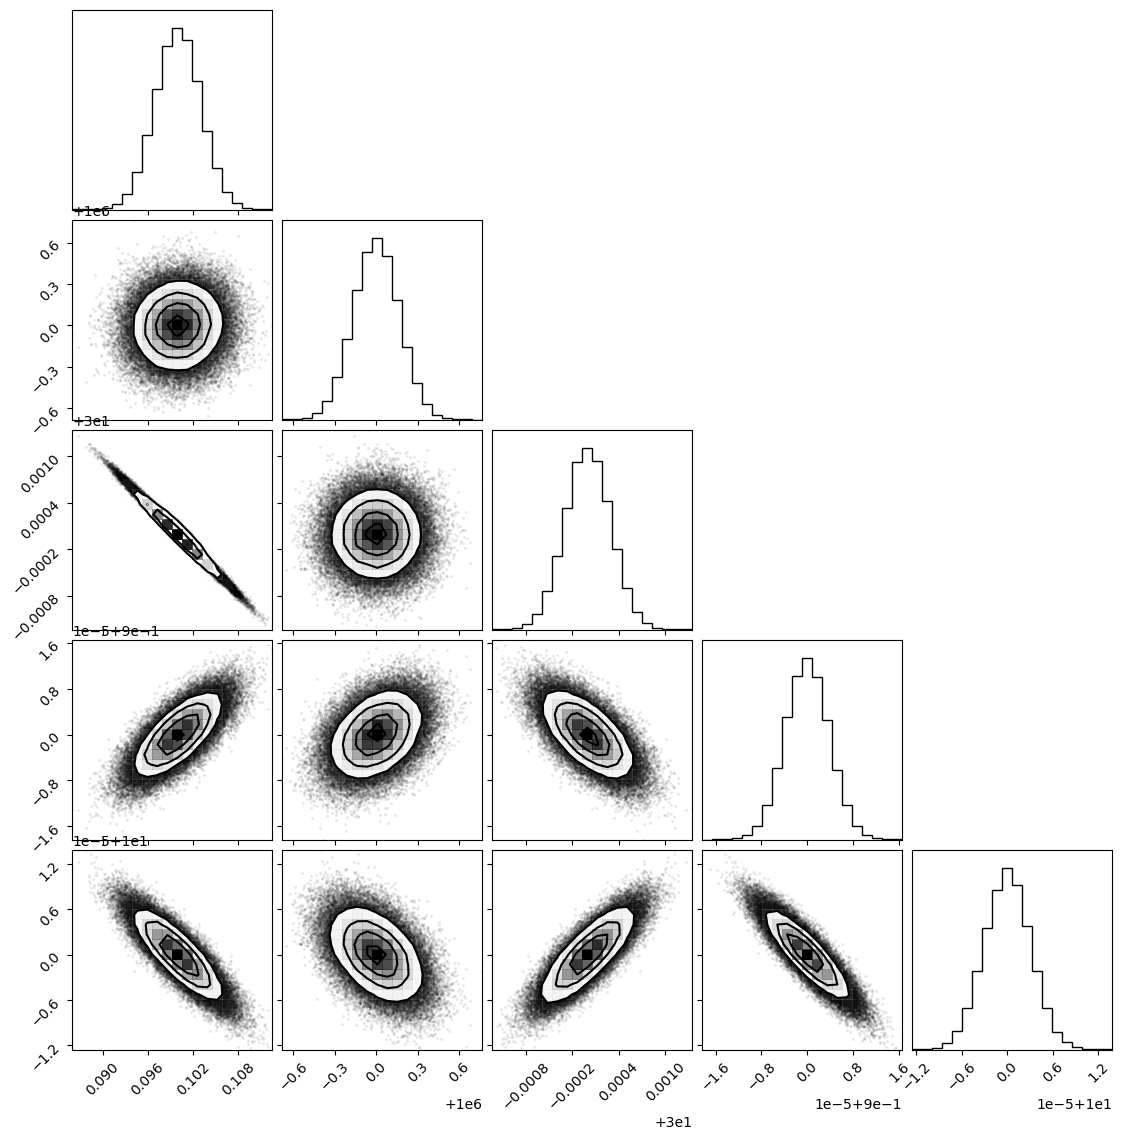

In [98]:
[Cref, M, mu, aref, p0]
plot_covariance_corner(refparamsred,cov,nsamp=100000,kwargs={'labels':['C', 'M',r'$\mu$',r'$\chi$',r'$r_0$']})

## some extra function tries done at some point to get familiar with the code



In [ ]:
fn = np.logspace(-5, -1, 10000)
fdwave7=kerr_gen_fd_GR(*injection_paramters7,frequencies=fn)
fdwave7mod=kerr_gen_fd_mod(*injection_paramters7,frequencies=fn)

In [ ]:
print(len(fdwave7[0]))
print(len(fn))
len(fdwave7[0][fn > 1e-3])

In [ ]:
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="LISASens",model=scirdv1, return_type="char_strain")
plt.loglog(fn[fn > 1e-3][::2000], np.abs(fdwave7[0])[fn > 1e-3][::2000], label = 'FD')
plt.loglog(fn[fn > 1e-3][::2000], np.abs(fdwave7mod[0])[fn > 1e-3][::2000], label = 'FD mod')
plt.loglog(fn, Sn_char_strain)
plt.ylabel("$|\\tilde{h}_+(f)|$")
plt.xlabel("$f$ (Hz)")
plt.legend()

plt.show()

In [ ]:
sens_mat2 = AE1SensitivityMatrix(fn, model=lisa_models.scirdv1)

sens_mat2.loglog()

In [ ]:
h7mod = kerr_gen_td_mod(*injection_paramters7)
h9mod = kerr_gen_td_mod(*injection_paramters9)

t7gr = np.arange(h7gr.shape[0])*dt/60./60./24.
t7mod = np.arange(h7mod.shape[0])*dt/60./60./24.

t9gr = np.arange(h9gr.shape[0])*dt/60./60./24.
t9mod = np.arange(h9mod.shape[0])*dt/60./60./24.

inspiral_gen_GR = InspiralGenerator(trajectory_data=trajdata_GR)
inspiral_gen_mod = InspiralGenerator(trajectory_data=trajdata_mod)
    
insmod=inspiral_gen_mod(M,mu,a,p0,dt,T)